In [1]:
import numpy as np
import pandas as pd
from scipy.fft import fft
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import euclidean
import matplotlib.pyplot as plt

In [2]:
nombre_csv= 1
df= pd.read_csv(f'../Datos_activ/{nombre_csv}cow.csv')
df

,Fecha,Hora,period eating,period other,period resting,period rumination,activity_level,T,RH,WS
0,2024-01-01,0,0.079,0.0,0.410,0.512,-0.209409,14.57,95.75,0.11
1,2024-01-01,1,0.000,0.0,0.653,0.347,-0.328245,14.32,95.00,0.18
2,2024-01-01,2,0.000,0.0,0.442,0.558,-0.248554,14.27,92.56,0.27
3,2024-01-01,3,0.000,0.0,0.463,0.537,-0.256485,14.36,89.38,0.22
4,2024-01-01,4,0.000,0.0,0.711,0.289,-0.350151,14.58,85.94,0.14
...,...,...,...,...,...,...,...,...,...,...
3931,2024-06-30,19,1.000,0.0,0.000,0.000,0.261935,14.48,99.25,0.80
3932,2024-06-30,20,0.450,0.0,0.000,0.550,0.072982,14.14,99.12,0.81
3933,2024-06-30,21,0.000,0.0,0.449,0.551,-0.251197,13.72,99.69,0.65
3934,2024-06-30,22,0.308,0.0,0.102,0.590,-0.014326,13.48,99.81,0.60


# Aplicacion de cliclo circadiano

In [3]:
df_c = df.copy()
# Convertir 'Fecha' y 'Hora' a datetime
df_c['datetime'] = pd.to_datetime(df_c['Fecha'] + ' ' + df_c['Hora'].astype(str) + ':00:00')
df_c = df_c.set_index('datetime')
df_c = df_c.sort_index()

# Función para calcular la Transformada de Fourier y extraer el ciclo circadiano
def extract_circadian_cycle(data):
    fft_result = fft(data)
    n = len(data)
    freq = np.fft.fftfreq(n, d=1/24)
    
    # Filtrar frecuencias cercanas a 1 ciclo por día
    fft_filtered = fft_result.copy()
    fft_filtered[(freq < 0.8) | (freq > 1.2)] = 0
    
    # Reconstruir la señal
    return np.real(np.fft.ifft(fft_filtered))

# Calcular el ciclo circadiano para cada día
daily_cycles = {}
for date, group in df_c.groupby(df_c.index.date):
    if len(group) == 24:  # Asegurarse de que hay 24 horas de datos
        daily_cycles[date] = extract_circadian_cycle(group['activity_level'].values)

# Calcular el ciclo circadiano promedio
average_cycle = np.mean(list(daily_cycles.values()), axis=0)

# Calcular la distancia absoluta entre cada hora del ciclo promedio y cada día
hourly_distances = []
for date, cycle in daily_cycles.items():
    for hour in range(24):
        hourly_distances.append({
            'Fecha': date,
            'Hora': hour,
            'distancia': abs(average_cycle[hour] - cycle[hour])
        })

# Convertir las distancias horarias a un DataFrame
distance_df = pd.DataFrame(hourly_distances)

# Calcular los umbrales para los niveles de estrés
min_distance = distance_df['distancia'].min()
max_distance = distance_df['distancia'].max()
threshold1 = min_distance + (max_distance - min_distance) / 2
#threshold2 = min_distance + 2 * (max_distance - min_distance) / 4
threshold2 = threshold1 + (max_distance - threshold1) /2
threshold3 = max_distance

# Función para determinar el nivel de estrés
def get_stress_level(distance):
    if distance <= threshold1:
        return 'normal'
    elif distance <= threshold2:
        return 'alerta'
    else:
        return 'peligro'

# Aplicar la función a las distancias y crear una columna de niveles de estrés
distance_df['stress_level'] = distance_df['distancia'].apply(get_stress_level)

distance_df

,Fecha,Hora,distancia,stress_level
0,2024-01-01,0,0.033277,normal
1,2024-01-01,1,0.029249,normal
2,2024-01-01,2,0.023227,normal
3,2024-01-01,3,0.015623,normal
4,2024-01-01,4,0.006954,normal
...,...,...,...,...
3931,2024-06-30,19,0.030342,normal
3932,2024-06-30,20,0.043932,normal
3933,2024-06-30,21,0.054528,alerta
3934,2024-06-30,22,0.061408,alerta


# grafica

C:\Users\PC\AppData\Local\Temp\ipykernel_8268\441255541.py:20: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


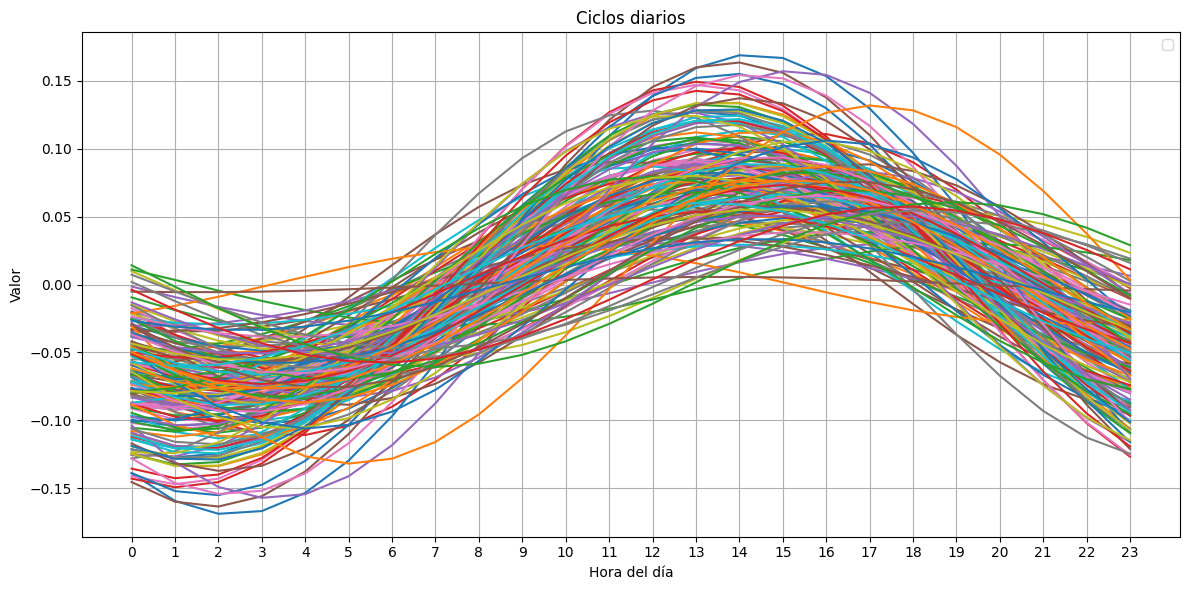

In [4]:
# Asumiendo que ya tienes tu diccionario daily_cycles

# Crear la figura y los ejes
fig, ax = plt.subplots(figsize=(12, 6))

# Graficar cada día
for date, values in daily_cycles.items():
    ax.plot(range(24), values)

# Configurar el eje x
ax.set_xticks(range(24))
ax.set_xticklabels(range(24))
ax.set_xlabel('Hora del día')

# Configurar el eje y
ax.set_ylabel('Valor')

# Añadir título y leyenda
ax.set_title('Ciclos diarios')
ax.legend()

# Mostrar la gráfica
plt.grid(True)
plt.tight_layout()
plt.savefig(f'../Ciclos circadianos/{nombre_csv}_diario.png', format='png', dpi=300)
plt.show()

C:\Users\PC\AppData\Local\Temp\ipykernel_8268\3328628228.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


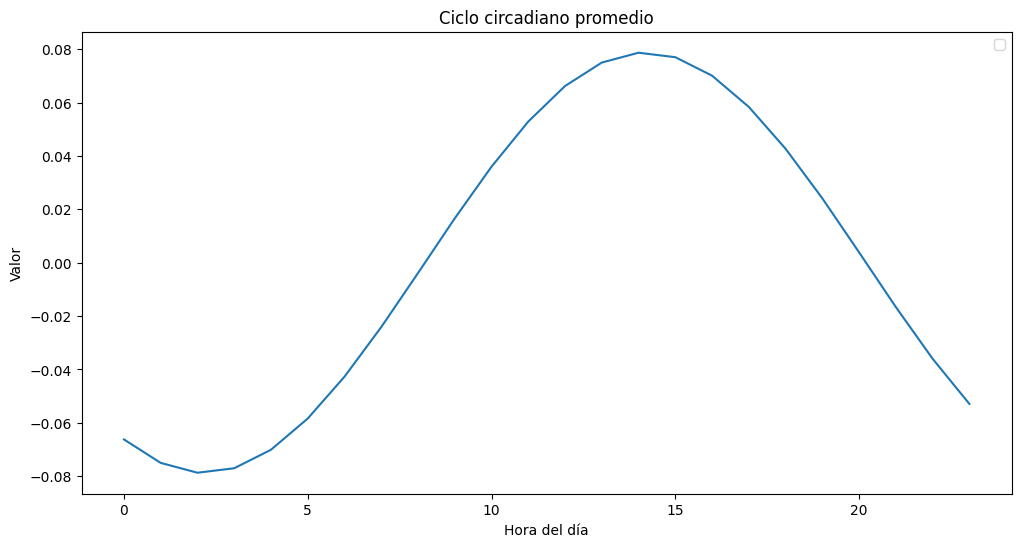

In [5]:
# Crear la gráfica de líneas
plt.figure(figsize=(12, 6))
plt.plot(average_cycle)

plt.title('Ciclo circadiano promedio')
plt.xlabel('Hora del día')
plt.ylabel('Valor')
plt.legend()
plt.savefig(f'../Ciclos circadianos/{nombre_csv}_promedio.png', format='png', dpi=300)
plt.show()

In [6]:
# Contar los niveles de estrés
stress_counts = distance_df['stress_level'].value_counts()

print(stress_counts)

stress_level
normal     3426
alerta      384
peligro     126
Name: count, dtype: int64
